<img style="float: left;" src="../earth-lab-logo-rgb.png" width="150" height="150">

# Earth Data Science Corps Summer 2020

![Colored Bar](../colored-bar.png)

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

After completing this lesson, you will be able to:

* Create a list of landsat `.tif` files using `glob` and `os.path.join`
* Crop a list of landsat `.tif` files to a defined crop extent boundary
* Stack a list of landsat `.tif` files into one output `.tif` file OR one **numpy** array

</div>

### Landsat File Naming Convention

Landsat and many other satellite remote sensing data is named in a way that tells you a about:

* When the data were collected and processed
* What sensor was used to collect the data
* What satellite was used to collect the data.

And more. 

Here you will learn a few key components of the landsat 8 collection file name. The first scene that you work with below is named:

`LC080340322016072301T1-SC20180214145802`

At the start of the name, you see LC08:

* **L:** Landsat Sensor
* **C:** OLI / TIRS combined platform
* **08:** Landsat 8 (not 7)

* **034032:** The next 6 digits represent the path and row of the scene. This identifies the spatial coverage of the scene

Finally, you have a date. In your case as follows:

* **20160723:** representing the year, month and day that the data were collected.

The second part of the file name above tells you more about when the data were last processed. You can read more about this naming convention using the link below.

<a href="https://www.usgs.gov/faqs/what-naming-convention-landsat-collections-level-1-scenes?qt-news_science_products=0#qt-news_science_products" target="_blank">Learn more about Landsat 8 file naming conventions.</a>

As you work with these data, it is good to double check that you are working with the sensor (Landsat 8) and the time period that you intend. Having this information in the file name makes it easier to keep track of this as you process your data. 

## Open Landsat .tif Files in Python

Now that you understand the Landsat 8 Collection file naming conventions, you 
will bring the data into Python using **earthpy**. To begin, load your 
libraries and set up your working directory.

In [1]:
import os
from glob import glob  # File manipulation
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Download data and set working directory
data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

You will be working in the `landsat-collect` directory. Notice that the data in that directory are stored by individual band. Each file is a single geotiff (.tif) rather than one tif with all the bands which is what you worked with in the previous lesson with NAIP data.  

### Why Are Landsat Bands Stored As Individual Files?
 
Originally Landsat was stored in a file format called HDF - hierarchical
data format. However that format, while extremely efficient, is a bit more
challenging to work with. In recent years, USGS has started to make each band
of a landsat scene available as a `.tif` file. This makes it a bit easier to use
across many different programs and platforms.

The good news is that you already know how to work with .tif files in **Python**. You just need to learn how to batch process a series of `.tif` files to work with Landsat 8 Collections. 

## Generate a List of Files in Python
 
To begin, explore the Landsat files in your `cs-test-landsat` directory. Start with the data:

`data/cs-test-landsat/`

Landsat scenes are large. In order to make the process more effecient, you need to crop all of the data in your landsat scenes to be the size of our study area. You will be using `crop_all()` later in this lesson to achieve this goal. 

Below are all of the bands in our landsat data:

```
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band7.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1.xml',
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band5.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band1.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_aerosol.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band3.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_ANG.txt',
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band2.tif',
'crop',
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band4.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band6.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_pixel_qa.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_radsat_qa.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_MTL.txt'

```

Notice that there are some layers that are quality assurance layers. Others have the word band in them. The layers with band in them are the reflectance data that you need to work with. 

To work with these files, you will do the following:

1. You will generate a list of all files in the directory that contain the word **band** in the name. 
2. Crop all layers in that list to the extent of the study area.
3. Stack all the layers into one numpy array.

You will use the `glob()` function and library to do this in **Python**. 

Begin exploring `glob()` by grabbing everything in the directory using `/*`. 

In [2]:
landsat_post_fire_path = os.path.join("cold-springs-fire",
                                      "landsat_collect",
                                      "LC080340322016072301T1-SC20180214145802",
                                      "crop")


glob(os.path.join(landsat_post_fire_path, "*"))

['cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band7_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_radsat_qa_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_aerosol_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_pixel_qa_crop.tif',
 'c

### Grab Subsets of File Names Using File Names and Other Criteria 

Above you generated a list of all files in the directory. However, you may want to subset that list to only include:

1. `.tif` files
2. `.tif` files that contain the word "band" in them

Note that it is important that the file **ends with** .tif. So we use an asterisk at the end of the path to tell Python to only grab files that end with .tif.

`path/*.tif` will grab all files in the crop directory that end with the .tif extension. 

In [3]:
glob(os.path.join(landsat_post_fire_path, "*.tif"))

['cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band7_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_radsat_qa_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_aerosol_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_pixel_qa_crop.tif',
 'c

To only grab files containing the word band AND that end with `.tif` we use `*band*.tif`.
This tells python to look for the word band anywhere before the `.tif` extension AND anywhere within the file name. 


In [4]:
all_landsat_post_bands = glob(os.path.join(
    landsat_post_fire_path, "*band*.tif"))
all_landsat_post_bands

['cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band7_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif']

Be sure that your bands are in order starting at 1 and ending at 7! If the data are not in order, you can use the `.sort()` list method to sort your list alphabetically. The data in this lesson are sorted properly; however, we have noticed that this sort doesn't happen by default on some machines. The code below will sort your list.

In [5]:
all_landsat_post_bands.sort()
all_landsat_post_bands

['cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band7_crop.tif']

In the previous lesson, you learned how to stack and plot landsat bands. Like this:


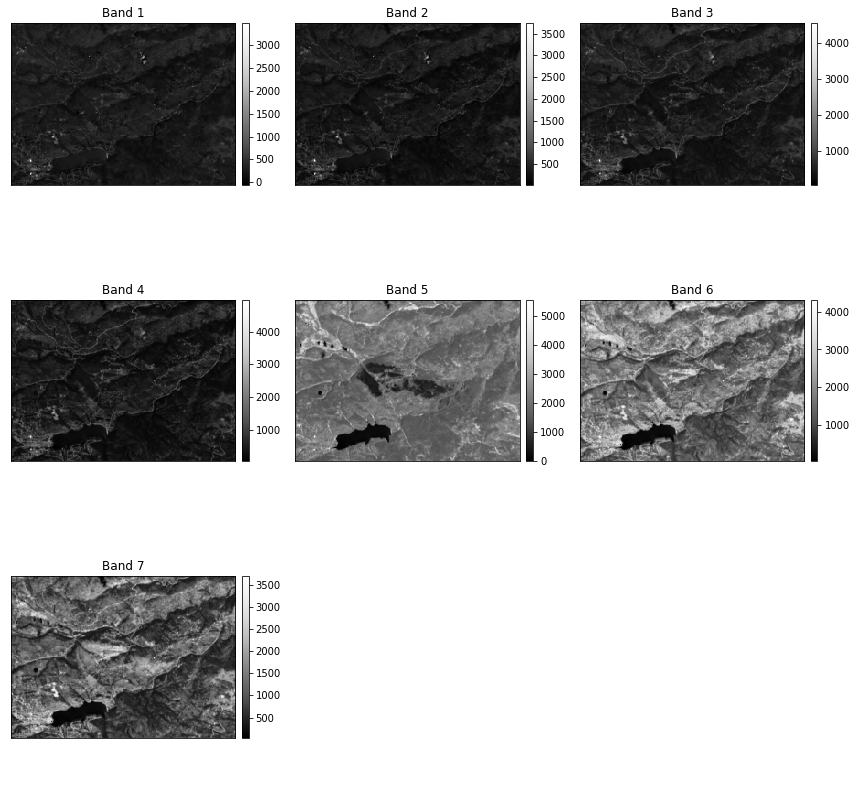

In [6]:
landsat_post_arr, landsat_post_meta = es.stack(all_landsat_post_bands)
ep.plot_bands(landsat_post_arr)
plt.show()

### Crop a Single Landsat Band Using EarthPy crop_image()

Above you opened up the data and plotted. But sometimes you want to crop
your data to just your study area - removing some of the data that you 
don't need in your analysis. You could chose to open and crop each file 
individually using the `rio.open()` (rasterio library) function alongside 
the **earthpy** `es.crop_image()` function as shown below.

In order to crop a band, you need to have a

1. **GeoPandas** or **shapely** object that represents the extent of the area you want to study in the Landsat image (your crop extent). 
2. The crop extent shapefile and the Landsat data need to be in the same Coordinate Reference System, or CRS. 

HINT: You can check the CRS of your Landsat data using the metadata object returned from `rasterio`. 

Below you crop a single band - band 4 of your data. Remember that Python uses 0 based indexing so 
band 4 is actually at index `[3]` not `[4]`.

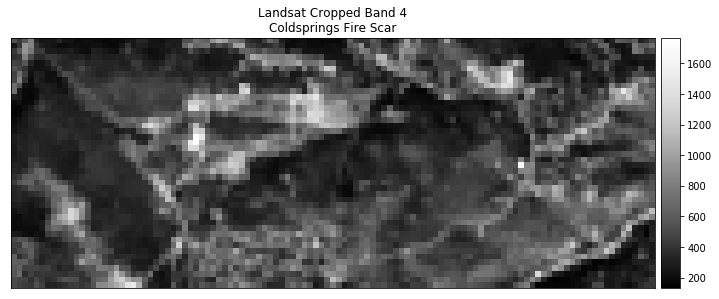

In [7]:
# Open up boundary extent in GeoPandas

fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

fire_boundary = gpd.read_file(fire_boundary_path)

# Open a single band and plot
with rio.open(all_landsat_post_bands[3]) as src:

    # Reproject the fire boundary shapefile to be the same CRS as the Landsat data
    crop_raster_profile = src.profile
    fire_boundary_utmz13 = fire_boundary.to_crs(crop_raster_profile["crs"])

    # Crop the landsat image to the extent of the fire boundary
    landsat_band4, landsat_metadata = es.crop_image(src, fire_boundary_utmz13)

ep.plot_bands(landsat_band4[0],
              title="Landsat Cropped Band 4\nColdsprings Fire Scar",
              scale=False)

plt.show()

### Crop A Set of Landsat .Tif Files Using a List of File Paths  (Earthpy crop_all)

Above you saw how to crop a single band of data. However, often you need to crop
all of your data at once. You can use the `EarthPy` function - `crop_all()` 
to crop many files in the same CRS at once. `crop_all()` takes a list of geotif 
file paths and crops them to the spatial extent of a **shapely** or **geopandas**
object. The function returns return a list of the cropped files which you can then 
use with the earthpy `stack()` function to create a stacked numpy array. 

To use **earthpy** `crop_all()`, you need to:

1. define (and create) an output folder where the cropped files will be saved. 
2. create a list of the paths to the tif files that you want to crop.
3. provide a crop extent layer which you will use to crop. This layer should be in the same CRS as your landsat data. 

In [8]:
cropped_dir = os.path.join("cold-springs-fire",
                           "outputs",
                           "landsat_post_crop")

# Make the directory if it doesn't already exist
if not os.path.isdir(cropped_dir):
    os.mkdir(cropped_dir)

# Crop your data
cropped_file_list = es.crop_all(raster_paths=all_landsat_post_bands,
                                output_dir=cropped_dir,
                                geoms=fire_boundary_utmz13,
                                overwrite=True,
                                verbose=True)

# Note that because the original tif files ended with _crop you have an awkward
# Output name. crop_all by default adds _crop to the end of your newly cropped files
cropped_file_list

['cold-springs-fire/outputs/landsat_post_crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop_crop.tif',
 'cold-springs-fire/outputs/landsat_post_crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop_crop.tif',
 'cold-springs-fire/outputs/landsat_post_crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop_crop.tif',
 'cold-springs-fire/outputs/landsat_post_crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop_crop.tif',
 'cold-springs-fire/outputs/landsat_post_crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop_crop.tif',
 'cold-springs-fire/outputs/landsat_post_crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop_crop.tif',
 'cold-springs-fire/outputs/landsat_post_crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band7_crop_crop.tif']

## Use EarthPy Stack() To Create Raster Stack of All Landsat Bands in Python

Once you have a list of tif files that you wish to work with in Python, you 
can stack them. The **earthpy** `es.stack()` function takes 2 arguments:

1. a list of tif files that are all in the same crs and of the same extent
2. a path to a new file where the stacked raster will be saved

To call it you use the following:

`es.stack(list-of-files-to-stack)`

Note that this stack function was written into the Earth Lab `earthpy` python 
package to make it simpler to stack sets of remote sensing files together.

In [9]:
# This will create a new stacked raster with all bands
land_stack, land_meta = es.stack(band_paths=cropped_file_list)
land_stack

array([[[ 269,  218,  307, ...,  191,  223,  335],
        [ 148,  244,  504, ...,  348,  335,  383],
        [ 255,  291,  578, ...,  326,  319,  359],
        ...,
        [ 266,  275,  222, ...,  215,  162,  155],
        [ 275,  275,  283, ...,  238,  228,  226],
        [ 282,  264,  271, ...,  259,  286,  296]],

       [[ 327,  267,  384, ...,  216,  251,  341],
        [ 167,  295,  582, ...,  410,  384,  438],
        [ 291,  341,  654, ...,  365,  340,  382],
        ...,
        [ 320,  350,  261, ...,  242,  193,  218],
        [ 301,  312,  316, ...,  269,  270,  273],
        [ 312,  293,  288, ...,  289,  320,  342]],

       [[ 524,  433,  573, ...,  413,  409,  486],
        [ 326,  451,  827, ...,  649,  576,  646],
        [ 501,  577,  850, ...,  604,  508,  551],
        ...,
        [ 520,  576,  412, ...,  357,  321,  367],
        [ 451,  480,  484, ...,  387,  398,  423],
        [ 482,  429,  430, ...,  417,  451,  468]],

       ...,

       [[1910, 1684, 213

### Plot Your Raster Stack

Once you have stacked your data, you can plot it or work with it as you need to.


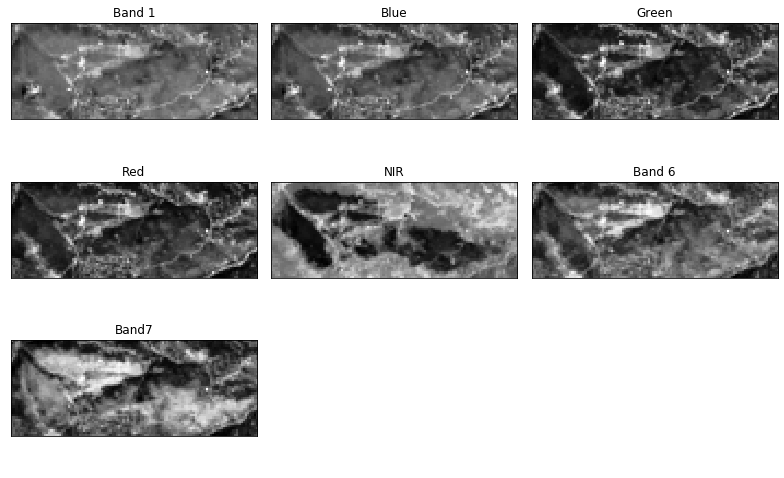

In [10]:
# Plot all bands using earthpy
band_titles = ["Band 1", "Blue", "Green", "Red",
               "NIR", "Band 6", "Band7"]

ep.plot_bands(land_stack,
              figsize=(11, 7),
              title=band_titles,
              cbar=False)
plt.show()

<div class='notice--success alert alert-info' markdown="1">

<i class="fa fa-star"></i> **Data Tip:** EarthPy Stack Function

In the example above, you opened and stacked some Landsat data. You can 
also create a new stacked .tif file if you wish by using the 

`outpath` parameter.

`es.stack(band_paths=list-of-files-to-stack, outpath="output/dir/filename.tif")`

You can learn more about stacking and cropped data by reading the 
<a href="https://earthpy.readthedocs.io/en/latest/gallery_vignettes/plot_raster_stack_crop.html#id1" target="_blank">earthpy documentation.</a>
</div>

<div class="notice--warning alert alert-info" markdown="1">

## <i class="fa fa-pencil-square-o" aria-hidden="true"></i> Challenge 1: Open And Crop Your Data

Above, you opened up the landsat scene in the directory: `LC080340322016072301T1-SC20180214145802`. This data covers 
an area which a file occured near Nederland, Colorado. For this challenge, you will
work with data that was collected before the fire for the same area. 
Do the following:

1. Crop all of the bands (tif files with the word "band" in them,  in the `LC080340322016070701T1-SC20180214145604` directory using earthpy `crop_all()`.
2. Next stack the cropped tif files using `es.stack()`.
3. Finally plot the data using `ep.plot_bands()`

</div>

In [11]:
# Use this cell to crop all the landsat bands and plot them


<div class="notice--warning alert alert-info" markdown="1">

## <i class="fa fa-pencil-square-o" aria-hidden="true"></i> Challenge 2 (Optional): Calculate & Plot NDVI 

In <a href="https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/landsat-in-Python/" target="_blank">this lesson which introduces working with Landsat data in open source 
    Python, </a> you learn how to plot both a color RGB and Color Infrared (CIR) images
    using landsat data. Create a figure below that has:

1. A color RGB image of the landsat data collected post fire
2. A CIR image of the landsat data collected post fire. 
 
HINT: You will need to set the correct band combinations for your plots to 
turn our properly. 

* For Regular color images use: `rgb=[3, 2, 1]`
* For color infrared use: `rgb=[4, 3, 2]`
</div>



In [12]:
# Use this cell to calculate and plot NDVI
